# COMP90051 Workshop 8
## Ensemble Learning
***
In this worksheet, we experiment with two ensemble learning algorithms: the Random Forest and Gradient Tree Boosting.
By the end of this worksheet, you should:
* be able to implement bootstrap aggregation (a.k.a. 'bagging'), particularly as applied to Random Forests; and
* be aware of Gradient Tree Boosting, and the features available in the scikit-learn implementation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc

### 1. Data set
We'll experiment with the "Bank Marketing" data set from the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/index.php).

The data contains records for 45,211 telemarketing customer interactions at a Portuguese bank.
The goal is to predict whether the customer will sign up for the product—i.e. a binary classification task.
There are 16 mixed (categorical/numeric) features for each customer interaction.
Further details are provided [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The code block below downloads the data from the repository, unzips it, and reads the full CSV file into a `pandas.DataFrame`.

In [2]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip')
zipfile = ZipFile(BytesIO(resp.read()))

df = pd.read_csv(zipfile.open('bank-full.csv'), header=0, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Notice that several features are categorical.
This is a problem, since the tree-based learners in `sklearn` don't support categorical features.
We must therefore apply feature encoding.

A straightforward solution is to apply the `pandas.get_dummies` function to one-hot encode all of the categorical columns in the DataFrame.
We then cast the result to a NumPy array called `X`.
Notice that we exclude the target variable, which is stored in column `y`.

We also re-encode the target variable—`0` for 'no' and `1` for 'yes'—and cast to a NumPy array.

In [3]:
df_transformed = pd.get_dummies(df.drop('y', axis=1))
X = df_transformed.values
Y = df.y.map({'no':0, 'yes':1}).values

**Question:** Can you identify any issues with the feature encoding? (Hint: look at `df_transformed.columns`)

**Question:** Are the classes balanced?

As usual, we partition the data into train/test sets.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

### 2. Implementation of Random Forest
In this section, we'll implement a Random Forest using `sklearn.tree.DecisionTreeClassifier` as the base learner.

The pseudo-code for the Random Forest training algorithm is as follows:
```
Parameters: n_trees (number of trees); max_features (size of random feature subset)
Initialise empty forest.
While size of forest is less than n_trees:
    Create a bootstrap sample from the training data.
    Train a decision tree on the sample (with max_features randomly-selected features available for each split).
    Add tree to forest.
```

**Question:** How does this algorithm differ to the one presented in lectures?

**Question:** Why are we using random subsets of features?

Complete the following code block, with reference to the pseudo-code above.

In [7]:
def fit_forest(X, Y, n_trees, **kwargs):
    """
    Fit a Random Forest
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape (n_instances,)
    n_trees : int
        number of trees in the forest
    *kwargs : keyword arguments passed to DecisionTreeClassifier
    
    Returns
    =======
    a dictionary with two keys:
      'forest' : list of DecisionTreeClassifier instances
      'oob_score' : the out-of-bag accuracy
    """
    forest = []
    n_instances = X.shape[0]
    n_features = X.shape[1]
    
    # A matrix to store the out-of-bag predictions for each tree (in-bag are left as 'nan')
    oob_all_predictions = np.full([n_trees, n_instances], np.nan)
    
    for i in range(n_trees):
        bag_ids = ... # fill in
        tree = ... # fill in
        
        # Save predictions for out-of-bag instances
        oob_ids = np.setdiff1d(np.arange(n_instances), bag_ids)
        oob_all_predictions[i,oob_ids] = tree.predict(X[oob_ids])
        
        forest.append(tree) 
    
    # Compute the out-of-bag accuracy (majority vote)
    from scipy.stats import mode
    oob_vote_prediction = mode(oob_all_predictions, axis=0, nan_policy='omit')[0].flatten()
    oob_score = (oob_vote_prediction==Y).mean()
    
    return {'forest': forest, 'oob_score': oob_score}

Let's apply this function to fit a Random Forest of 100 trees to the Bank Marketing data. 
Note that a larger forest is generally better, but performance will diminish beyond a certain size.
By setting `max_features='sqrt'`, we're restricting each split to a random subset of features of size $\sqrt{\mathrm{num\ features}}$ (i.e. a subset of 8 features for this data).

We also print out the out-of-bag accuracy, which we computed while fitting the trees.

In [8]:
forest = fit_forest(X_train, Y_train, 100, max_features='sqrt')
print('Out-of-bag accuracy is {:.3g}'.format(forest['oob_score']))

Out-of-bag accuracy is 0.905


Let's now implement a function to make predictions on instances `X` using the forest we've just trained. 
Remember that for classification, a prediction is made by majority vote among trees in the forest.

In [9]:
def predict_forest(X, forest):
    """
    Make predictions using majority voting over the trees in the forest
    
    Arguments
    =========
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    forest : a list of DecisionTreeClassifier instances
    """
    # Allocate array to store predictions for each instance/tree
    n_instances = X.shape[0]
    n_trees = len(forest)
    predictions = np.empty([n_trees, n_instances], dtype=int)
    
    # Fill array
    for (i,tree) in enumerate(forest):
        predictions[i] = ... # fill in
    
    # Use majority vote (mode) for each instance
    from scipy.stats import mode
    return mode(predictions, axis=0)[0].flatten()

We'll use the `predict_forest` function to compute the accuracy on the test set. 
You should compare the test accuracy to the out-of-bag accuracy computed previously.

In [10]:
Y_test_pred = predict_forest(X_test, forest['forest'])
test_acc = ... # fill in
print('The test accuracy is {:.3g}'.format(test_acc))

The test accuracy is 0.908


### 3. Random Forest in sklearn
Let's take a look at the Random Forest implementation available in `sklearn`.
Since the underlying algorithm is the same, you should get very similar results (excluding variance due to randomisation).

In [11]:
clf_rf = RandomForestClassifier(oob_score=True, n_estimators=100).fit(X_train, Y_train)
print('Out-of-bag accuracy is {:.3g}'.format(clf_rf.oob_score_))
print('The test accuracy is {:.3g}'.format(clf_rf.score(X_test, Y_test)))

Out-of-bag accuracy is 0.905
The test accuracy is 0.907


The `sklearn` implementation includes additional functionality. For example:
* it supports training trees in parallel
* it can return information about the importance of each feature
* it can compute class probabilities

Below we plot the relative importance of each feature.

**Question:** Does the feature importance make intuitive sense? Remember, we're trying to predict whether a customer will sign up for a term deposit after receiving a call from a telemarketer.

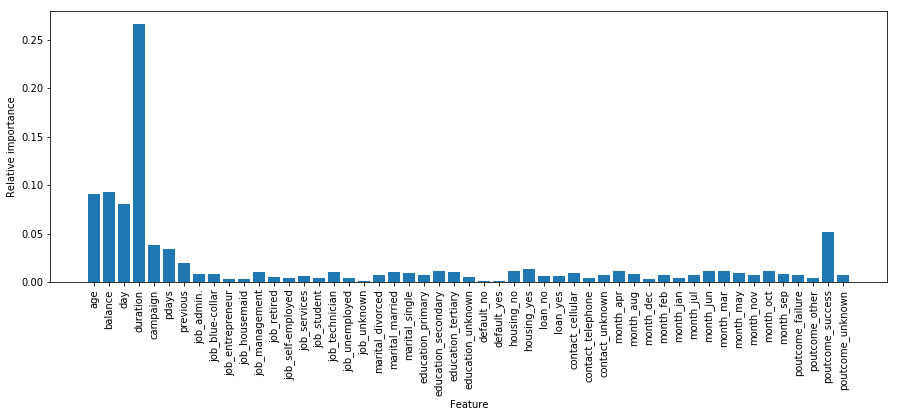

In [13]:
Y_pred = clf_rf.predict(X_test)
fig, ax = plt.subplots(figsize=[15,5])
ax.bar(df_transformed.columns, clf_rf.feature_importances_)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Relative importance')
plt.show()

For imbalanced classification problems, accuracy can be a misleading metric.
Below we compute the area-under-curve (AUC).
If we really care about identifying customers who'll sign up, then precision/recall would be appropriate.

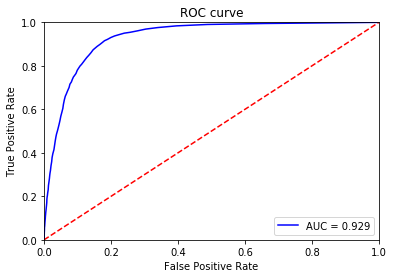

In [14]:
fpr, tpr, thrseshold = roc_curve(Y_test, clf_rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %.3g' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4. Gradient tree boosting
In this section, we'll test out another ensemble learning algorithm called _gradient tree boosting_.
Like AdaBoost (presented in lectures), gradient tree boosting involves sequentially training an ensemble of weak learners.
However, unlike AdaBoost, it allows for the optimisation of an arbitrary differentiable loss function—not only the exponential loss.
`sklearn.ensembles.GradientBoostingClassifier` implements gradient tree boosting for the logistic loss as well as the exponential loss (AdaBoost).

Unlike Random Forests, gradient tree boosting is prone to overfitting.
Ideally, one should tune the parameters (including the maximum tree depth and the number of trees) using cross validation.
Below we perform a grid search over the maximum tree depth `max_depth`.

In [15]:
grid = GridSearchCV(GradientBoostingClassifier(), param_grid = {'max_depth': [3, 5, 8]})
grid.fit(X_train, Y_train)
print('Best parameter(s) are {0.best_params_} with score {0.best_score_:.4g}'.format(grid))

Best parameter(s) are {'max_depth': 3} with score 0.9057


Let's now re-run training using the best parameters without cross-validation.

In [16]:
clf_gb = GradientBoostingClassifier(**grid.best_params_).fit(X_train, Y_train)

Compute the accuracy on the test set below.
You should compare the performance of gradient tree boosting with the Random Forest.

In [17]:
test_acc = ... # fill in
print('Test accuracy is {:.3g}'.format(test_acc))

Test accuracy is 0.906


The `GradientBoostingClassifier` also computes the feature importance.
How does the feature importance compare with the `RandomForestClassifier`?

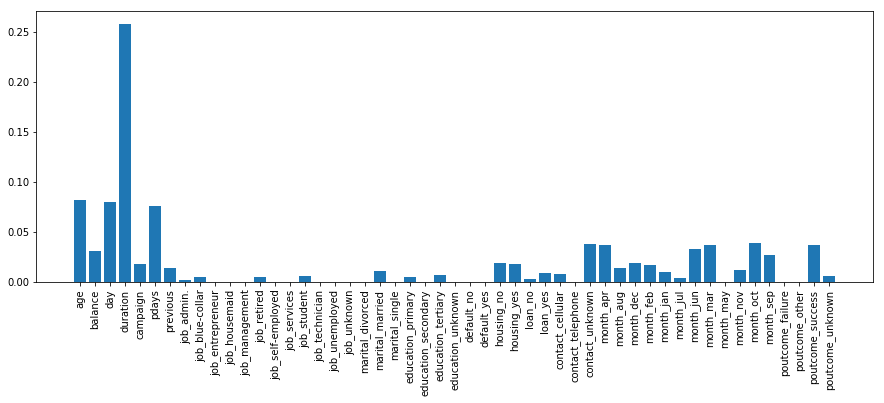

In [18]:
fig, ax = plt.subplots(figsize=[15,5])
ax.bar(df_transformed.columns, clf_gb.feature_importances_)
plt.xticks(rotation=90)
plt.show()

And how does the ROC curve/AUC compare?

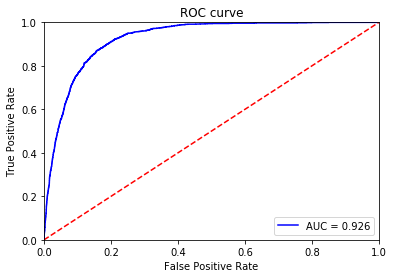

In [19]:
fpr, tpr, threshold = roc_curve(Y_test, clf_gb.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3g' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()